# FSDL Project
This Notebook is used to train a ResNet-50 model on Amazon Planet Dataset (MultiLabel Classification Problem)

Used Fast AI for eaiser training and inference rather than PyTorch or Tensorflow

## Load Dataset into the Drive using Kaggle API

Follow Kaggle API instruction to download the kaggle.json file and unzip the files in the current directory

In [ ]:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

In [ ]:
from google.colab import files 
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download nikitarom/planets-dataset

100% 1.49G/1.50G [01:33<00:00, 30.7MB/s]
100% 1.50G/1.50G [01:34<00:00, 17.1MB/s]


In [ ]:
!unzip planets-dataset.zip

## Loading and Visualizing Dataset

In [6]:
from fastai.vision.all import *
path = Path('./planet/planet')

In [7]:
path.ls()

(#4) [Path('planet/planet/test-jpg'),Path('planet/planet/sample_submission.csv'),Path('planet/planet/train_classes.csv'),Path('planet/planet/train-jpg')]

In [8]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [9]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(1, label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [10]:
dls = get_data(128,256)

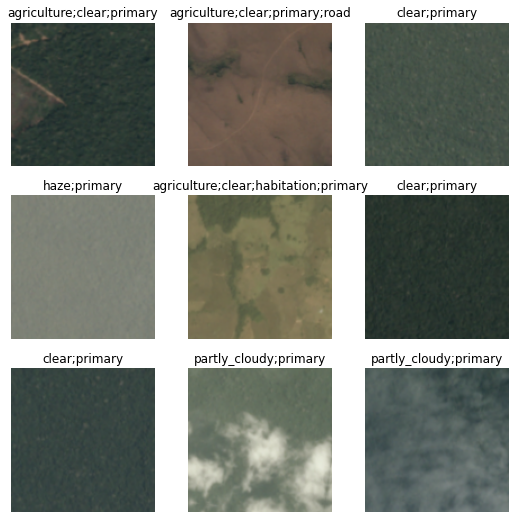

In [11]:
dls.show_batch()

## Train & Save ResNet-50 Model

In [12]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta=2, average='samples', thresh=0.2)]
cbs = [MixUp]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.02754228748381138)

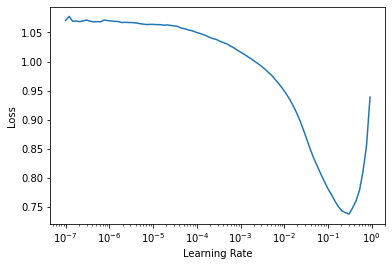

In [13]:
learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs).to_fp16()
learn.lr_find()

In [14]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.363824,0.135795,0.934556,0.878567,03:29
1,0.188823,0.118180,0.935131,0.895808,03:27
2,0.167116,0.108358,0.944926,0.905981,03:27
3,0.156562,0.108537,0.941068,0.906830,03:27


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.148053,0.102802,0.955543,0.913901,04:20
1,0.146838,nan,0.945973,0.897842,04:18
2,0.142384,0.096861,0.951822,0.913915,04:18
3,0.138144,0.091123,0.954831,0.920376,04:17
4,0.133395,0.087194,0.954918,0.924520,04:18
5,0.130392,0.085676,0.956407,0.926633,04:18


In [15]:
learn.save('resnet50-128')

Path('models/resnet50-128.pth')

## Results of the Model

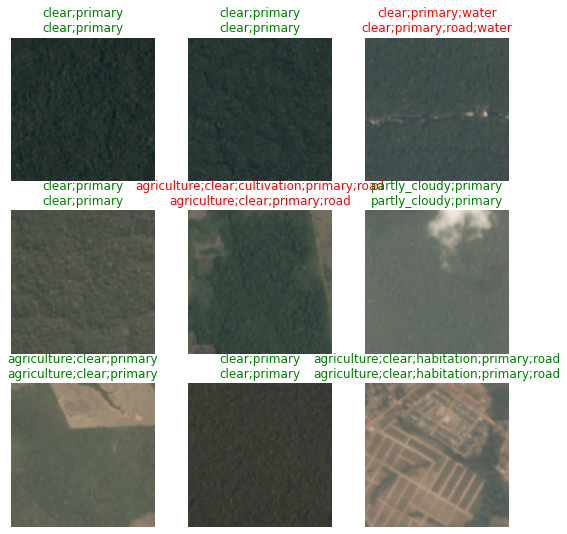

In [21]:
learn.show_results()

## Prediction and Inference of the Model

In [22]:
learn.export() # if we want .pkl file for proper end to end deployment (file will be saved as export.pkl)

In [27]:
#inference = learn.load('resnet50-128')

In [28]:
additional_test_path = Path('test-jpg-additional/test-jpg-additional')
test_path = Path('planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [29]:
prediction('submission_tta.csv', tta=True)

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear partly_cloudy primary
4,test_4,cloudy partly_cloudy primary
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,clear primary water
61188,file_9997,clear primary road water
61189,file_9998,cloudy
